**数据集**
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud




**参考链接**
1. https://tensorflow.google.cn/tutorials/generative/autoencoder#third_example_anomaly_detection
2. https://towardsdatascience.com/anomaly-detection-using-autoencoders-5b032178a1ea
   

In [145]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model


In [146]:
dataframe = pd.read_csv('creditcard.csv')
dataframe.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


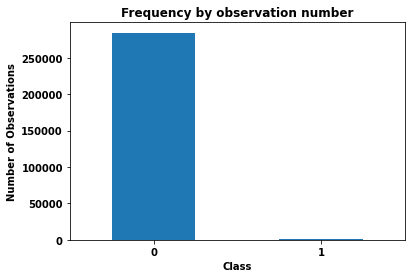

In [147]:
#Visualizing the imbalanced dataset
count_classes = pd.value_counts(dataframe['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(len(dataframe['Class'].unique())), dataframe.Class.unique())
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

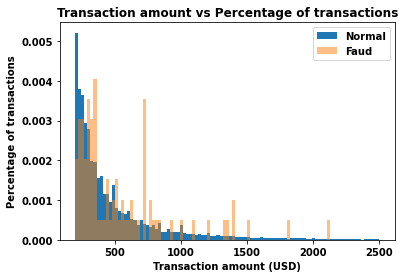

In [148]:
# 将正常交易和欺诈交易保存在单独的数据
normal_dataset = dataframe[dataframe.Class == 0] 
fraud_dataset = dataframe[dataframe.Class == 1]
#可视化正常和欺诈交易的交易金额
bins = np.linspace(200, 2500, 100) 
plt.hist(normal_dataset.Amount, bins=bins, alpha=1, density=True, label='Normal') 
plt.hist(fraud_dataset.Amount, bins=bins, alpha=0.5, density=True, label='Faud') 
plt.legend(loc='upper right')
plt.title("Transaction amount vs Percentage of transactions")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions")
plt.show()

In [149]:
from sklearn.preprocessing import StandardScaler
# 标准化
sc=StandardScaler()
dataframe['Time'] = sc.fit_transform(dataframe['Time'].values.reshape(-1, 1))
dataframe['Amount'] = sc.fit_transform(dataframe['Amount'].values.reshape(-1, 1))

In [150]:
raw_data = dataframe.values

# 数据中的class即位label
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=2000
)

In [151]:
train_data.shape

(227845, 30)

In [152]:
train_labels.shape

(227845,)

In [153]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)


In [154]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

# normal_train_data = train_data[train_labels]
# normal_test_data = test_data[test_labels]

# anomalous_train_data = train_data[~train_labels]
# anomalous_test_data = test_data[~test_labels]

'''正常数据在目标变量中的值为 0。使用目标变量创建正常和欺诈数据集'''
# 这一步把
anomalous_train_data = train_data[train_labels]
anomalous_test_data = test_data[test_labels]

normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]

In [155]:
nb_epoch = 20

input_dim = normal_train_data.shape[1] #num of columns, 30
encoding_dim = 14


In [156]:
class AnomalyDetector(Model):
  # it work多多少少有点奇怪
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      # main-key
      layers.Input(shape=normal_train_data.shape[1]),
      # layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(8, activation="relu"),
      # main-key
      layers.Dense(input_dim, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded



In [157]:
encoding_dim = 14
hidden_dim_1 = int(encoding_dim / 2) #
hidden_dim_2=4  


In [160]:
# class AnomalyDetector02(Model):
#     这个也work
#     def __init__(self):
#         super(AnomalyDetector02, self).__init__()
#         self.encoder = tf.keras.Sequential([

#             layers.Input(shape=(input_dim,)),
#             layers.Dense(encoding_dim,activation='tanh'),
#             layers.Dropout(0.2),
#             layers.Dense(hidden_dim_1,activation='relu'),
#             layers.Dense(hidden_dim_2,activation=tf.nn.leaky_relu)

#         ])
        
#         self.decoder = tf.keras.Sequential([
#             layers.Dense(hidden_dim_1,activation='relu'),
#             layers.Dropout(0.2),
#             layers.Dense(encoding_dim,activation='relu'),
#             layers.Dense(input_dim,activation='tanh')
#         ])

#     def call(self,x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded

In [171]:
autoencoder = AnomalyDetector()

In [172]:
autoencoder.compile(optimizer='adam', loss='mae')

In [173]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=10, 
          batch_size=64,
          validation_data=(test_data, test_data),
          shuffle=True,
)

Epoch 1/10
3554/3554 [==============================] - 4s 1ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 2/10
3554/3554 [==============================] - 4s 998us/step - loss: 0.0027 - val_loss: 0.0026
Epoch 3/10
3554/3554 [==============================] - 3s 962us/step - loss: 0.0026 - val_loss: 0.0025
Epoch 4/10
3554/3554 [==============================] - 4s 995us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 5/10
3554/3554 [==============================] - 3s 950us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 6/10
3554/3554 [==============================] - 3s 958us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 7/10
3554/3554 [==============================] - 4s 1ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 8/10
3554/3554 [==============================] - 3s 968us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 9/10
3554/3554 [==============================] - 3s 953us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 10/10
3554/3554 [==============================] - 3s 968us/st

In [174]:
autoencoder.summary()

Model: "anomaly_detector_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_20 (Sequential)  (None, 8)                 248       
                                                                 
 sequential_21 (Sequential)  (None, 30)                342       
                                                                 
Total params: 590
Trainable params: 590
Non-trainable params: 0
_________________________________________________________________


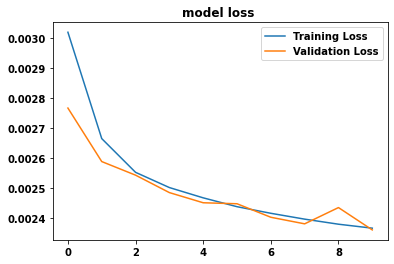

In [175]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("model loss ")
plt.legend()

In [176]:
# encoded_data = autoencoder.encoder(normal_test_data).numpy()
# decoded_data = autoencoder.decoder(encoded_data).numpy()

# plt.plot(normal_test_data[0], 'b')
# plt.plot(decoded_data[0], 'r')
# plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
# plt.legend(labels=["Input", "Reconstruction", "Error"])
# plt.show() 

In [177]:
# encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
# decoded_data = autoencoder.decoder(encoded_data).numpy()

# plt.plot(anomalous_test_data[0], 'b')
# plt.plot(decoded_data[0], 'r')
# plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
# plt.legend(labels=["Input", "Reconstruction", "Error"])
# plt.show()

In [178]:
'''为了计算测试数据的重建损失，预测测试数据并计算测试数据与重建测试数据之间的均方误差。

'''
test_x_predictions = autoencoder.predict(test_data)
mse = np.mean(np.power(test_data - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_labels})

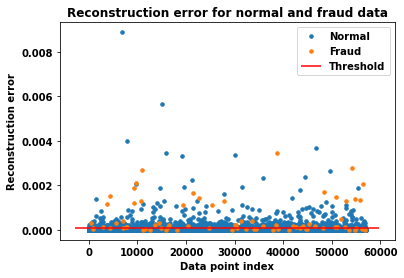

In [180]:
'''绘制测试数据点及其各自的重建误差会设置一个阈值，以便可视化是否需要调整阈值。'''
threshold_fixed = 0.0001
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()